In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from highlight_initializer import *
from baseline_evaluation import *
from utils import *
import copy
from highlight_extractor import *
from parameters import *
import warnings
warnings.filterwarnings("ignore")

C:\Anaconda2\envs\lightor\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Loading datasets

In [2]:
dota2_train_data = DataLoader('Dota2', 'train', **INITIAL_PARA)
dota2_test_data = DataLoader('Dota2', 'test', **INITIAL_PARA)
lol_train_data = DataLoader('LOL', 'train', **INITIAL_PARA)
lol_test_data = DataLoader('LOL', 'test', **INITIAL_PARA)

# Training models

In [3]:
dota2_model1 = train(dota2_train_data, [0])
dota2_model3 = train(dota2_train_data, [0, 1, 2])
dota2_model2 = train(dota2_train_data, [0, 1])
lol_model = train(lol_train_data, [0, 1, 2])
all_training_files = dota2_train_data.chat_filename_list
other_models = []
training_data = []
for i in range(1, 11):
    subfiles = all_training_files[:i]
    t = DataLoader('Dota2', 'train', subfiles=subfiles, **INITIAL_PARA)
    other_models.append(train(t, [0, 1, 2]))
    training_data.append(t)
expander = Adjustment(dota2_train_data, **EXPAND)
expander.train()

# Robustness of Constant C

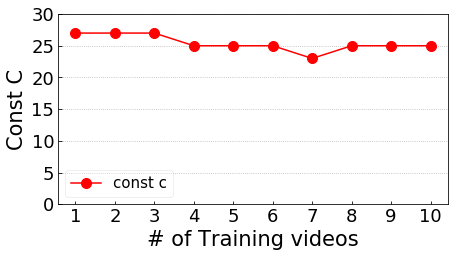

[27, 27, 27, 25, 25, 25, 23, 25, 25, 25]


In [4]:
const_c = []
for d in training_data:
    e = Adjustment(d, **EXPAND)
    e.train()
    const_c.append(e.const[0])
plot_precision([[const_c, '-ro', 'const c']], '# of Training videos', 'Const C', list(range(1, 11)), [0, 30], np.arange(0, 35, 5))
print(const_c)

# Robustness of Training Size

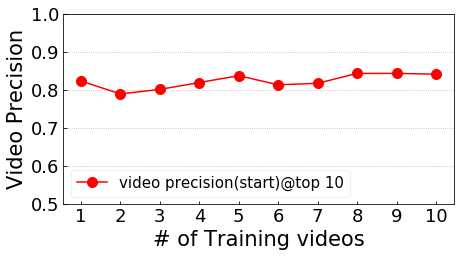

[0.824, 0.79, 0.802, 0.82, 0.838, 0.814, 0.818, 0.844, 0.844, 0.842]


In [5]:
prec = []
for m in other_models:
    test = deepcopy(dota2_test_data)
    apply_model(m, test, 120, [4, 5, 6])
    true_num = 0
    for f in test.chat:
        pred = test.predicted_labels[f][:10]
        true_num += len([p for p in pred if time(p) in test.baseline_gt[f]])
    prec.append(true_num / (10 * len(test.chat)))
plot_precision([[prec, '-ro', 'video precision(start)@top 10']], '# of Training videos', 'Video Precision', list(range(1, 11)), [0.5, 1.0], [0.5,0.6,0.7,0.8,0.9,1.0])
print(prec)

# Peak Example

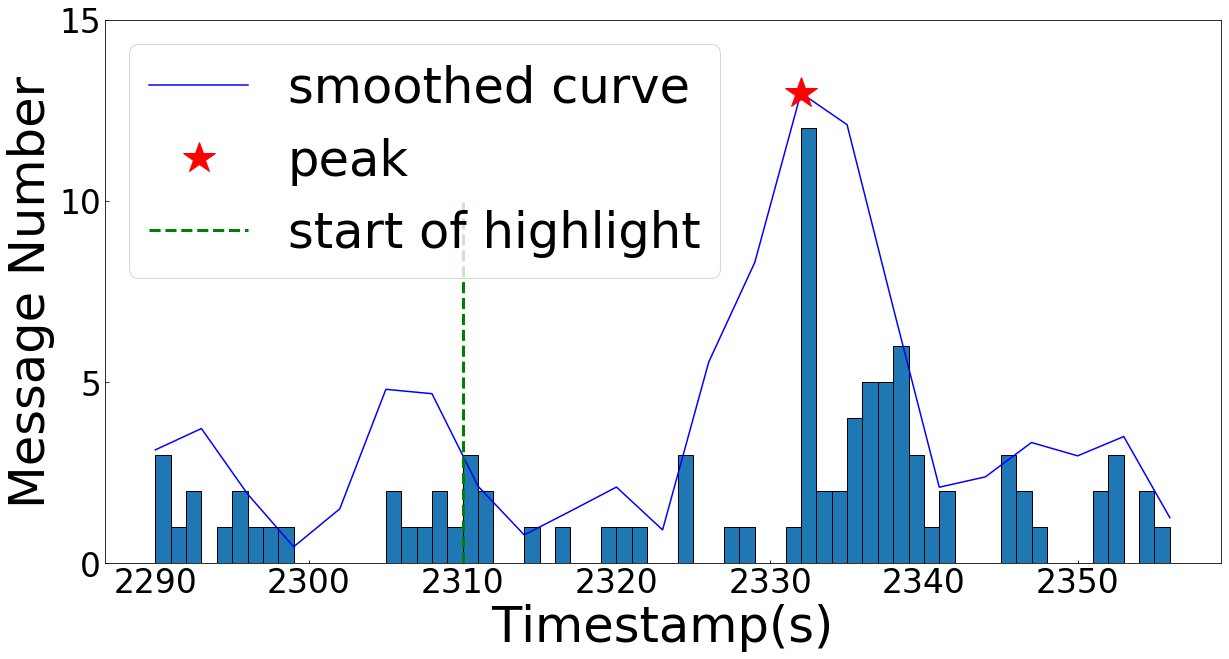

In [6]:
selected_file = 'sing_sing-2017-08-01-09h09m34s'
selected_time = ['038-42', '038-30', '038-45']
plot_peak(dota2_test_data, selected_file, sec(selected_time[0]), sec(selected_time[1]))

# Hist of Features

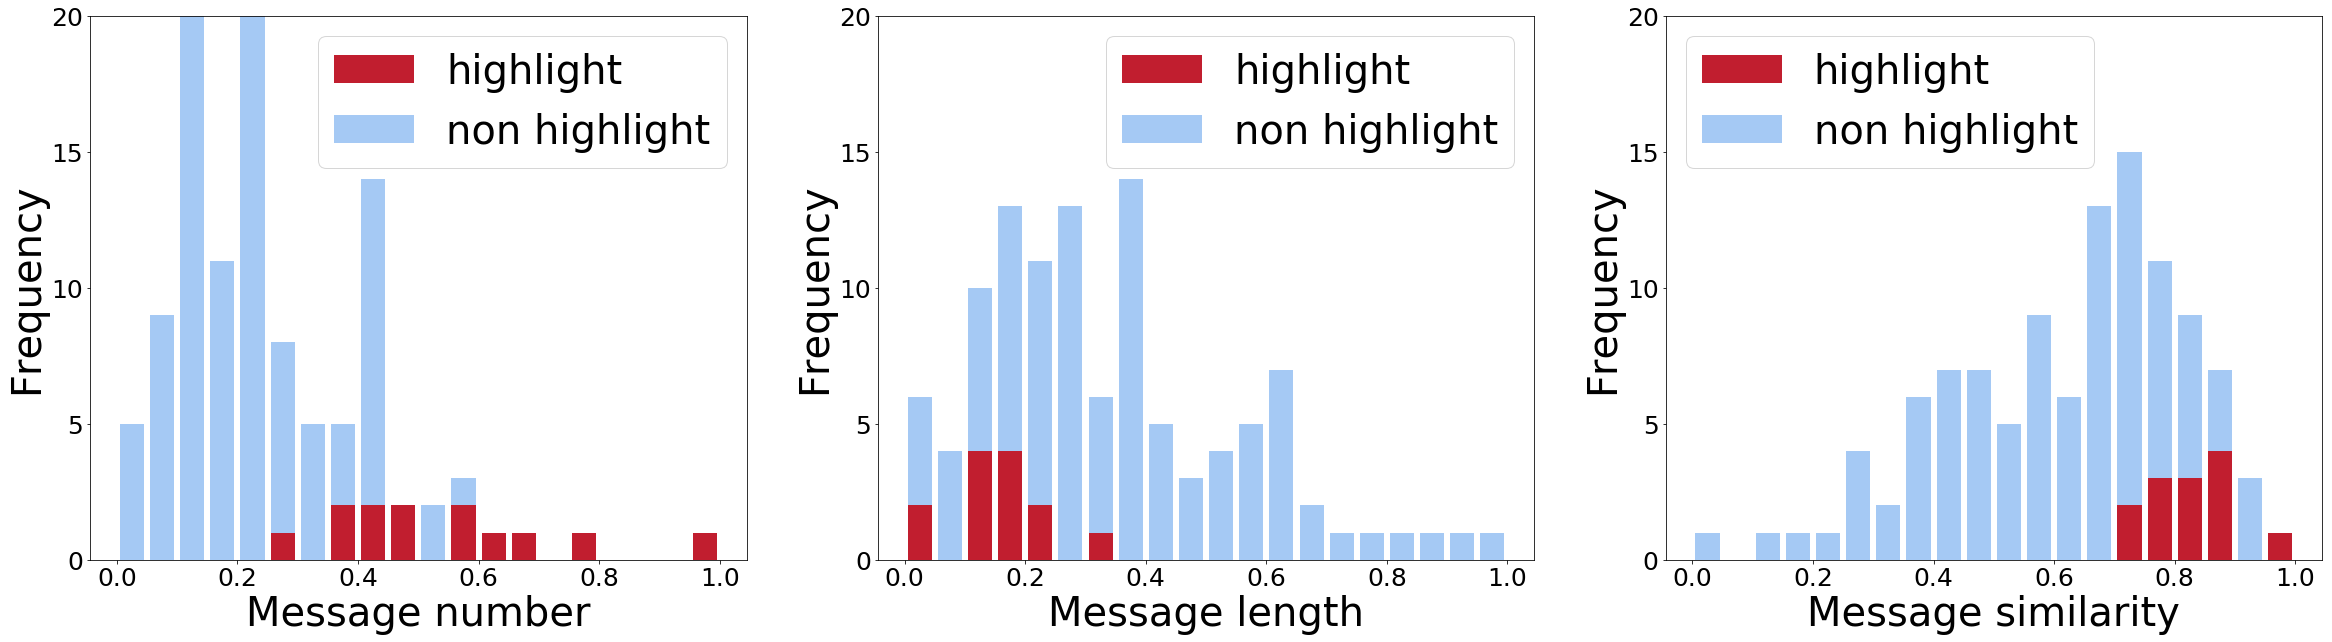

In [7]:
show_features(training_data[0])

# User Behavior

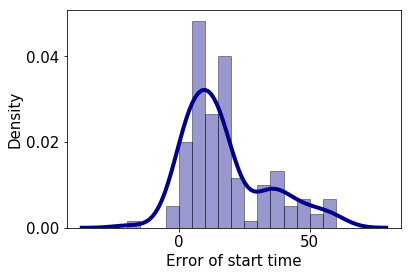

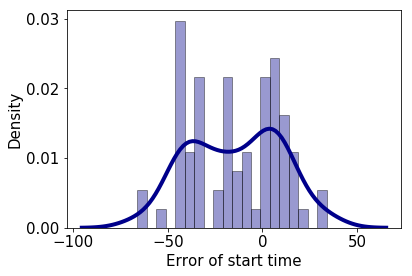

In [8]:
plot_behaviors("1")
plot_behaviors("2")

# Prediction

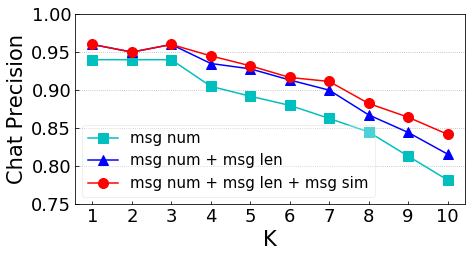

[[[0.94, 0.94, 0.94, 0.905, 0.892, 0.88, 0.8628571428571429, 0.845, 0.8133333333333334, 0.782], 'cs-', 'msg num'], [[0.96, 0.95, 0.96, 0.935, 0.928, 0.9133333333333333, 0.9, 0.8675, 0.8444444444444444, 0.816], '^b-', 'msg num + msg len'], [[0.96, 0.95, 0.96, 0.945, 0.932, 0.9166666666666666, 0.9114285714285715, 0.8825, 0.8644444444444445, 0.842], 'or-', 'msg num + msg len + msg sim']]


In [9]:
k = 10
dota2_test_data1 = copy.deepcopy(dota2_test_data)
dota2_test_data2 = copy.deepcopy(dota2_test_data)
dota2_test_data3 = copy.deepcopy(dota2_test_data)

apply_model(dota2_model1, dota2_test_data1, 120, [4])
ML_num = dota2_test_data1.predicted_labels
ML_num_precision = []

apply_model(dota2_model2, dota2_test_data2, 120, [4, 5])
ML_num_len = dota2_test_data2.predicted_labels
ML_num_len_precision = []

apply_model(dota2_model3, dota2_test_data3, 120, [4, 5, 6])
ML_num_len_sim = dota2_test_data3.predicted_labels
ML_num_len_sim_precision = []


gt = {}
for f in dota2_test_data.true_labels:
    gt[f] = [sec(j) for j in dota2_test_data.baseline_gt[f]]

for i in range(1, k + 1):
    true_num = [0, 0, 0]
    for f in gt:
        true_num[0] += len([p for p in ML_num[f][:i] if p in gt[f]])
        true_num[1] += len([p for p in ML_num_len[f][:i] if p in gt[f]])
        true_num[2] += len([p for p in ML_num_len_sim[f][:i] if p in gt[f]])
    ML_num_precision.append(true_num[0] / float(i * len(gt)))
    ML_num_len_precision.append(true_num[1] / float(i * len(gt)))
    ML_num_len_sim_precision.append(true_num[2] / float(i * len(gt)))

prec_list = [[ML_num_precision, 'cs-', 'msg num'],
             [ML_num_len_precision, '^b-', 'msg num + msg len'],
             [ML_num_len_sim_precision, 'or-', 'msg num + msg len + msg sim']
            ]

plot_precision(prec_list, 'K', 'Chat Precision', list(range(1, k + 1)), [0.75, 1.0], np.append(np.arange(0.75, 1.00, 0.05), [1]))
print(prec_list)

# Ajustment

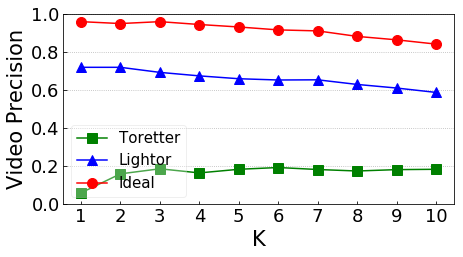

[[[0.06, 0.16, 0.18666666666666668, 0.165, 0.184, 0.19333333333333333, 0.18285714285714286, 0.175, 0.18222222222222223, 0.184], 'sg-', 'Toretter'], [[0.72, 0.72, 0.6933333333333334, 0.675, 0.66, 0.6533333333333333, 0.6542857142857142, 0.63, 0.6111111111111112, 0.588], '^b-', 'Lightor'], [[0.96, 0.95, 0.96, 0.945, 0.932, 0.9166666666666666, 0.9114285714285715, 0.8825, 0.8644444444444445, 0.842], 'or-', 'Ideal']]


In [10]:
dota2_test_data = DataLoader('Dota2', 'test', **INITIAL_PARA)
apply_model(dota2_model3, dota2_test_data, 120, [4, 5, 6])
expander.generate_peaks(dota2_test_data, **EXPAND)
expander.apply(dota2_test_data)

k = 10

no_moving = []
moving = []
ideal = []
for i in range(1, k + 1):
    true_num = [0, 0, 0]
    for f in dota2_test_data.predicted_labels:
        true_labels = [sec(j) for j in dota2_test_data.baseline_gt[f]]
        true_num[0] += len([p[0] for p in dota2_test_data.predicted_labels[f][:i] if p[0] in true_labels])
        true_num[1] += len([p[0] for p in dota2_test_data.predicted_labels[f][:i] if p[-1] in dota2_test_data.start_gt[f]])       
        true_num[2] += len([p[0] for p in dota2_test_data.predicted_labels[f][:i] if p[-2] in dota2_test_data.start_gt[f]])
        
    no_moving.append(true_num[2] / float(i * len(dota2_test_data.predicted_labels)))
    moving.append(true_num[1] / float(i * len(dota2_test_data.predicted_labels)))
    ideal.append(true_num[0] / float(i * len(dota2_test_data.predicted_labels)))


prec_list = [[no_moving, 'sg-', 'Toretter'],
             [moving, '^b-', 'Lightor'],
             [ideal, 'or-', 'Ideal']
            ]
plot_precision(prec_list, 'K', 'Video Precision', list(range(1, k + 1)), [0, 1], np.arange(0.0, 1.1, 0.2))
print(prec_list)

# Extractor (Start)

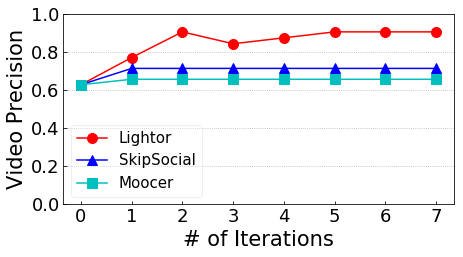

In [11]:
highlight_extractor = Highlight_Extractor(deepcopy(ORIGINAL_DATA))
highlight_extractor.process_all_iterations()

crowd_data = {}
for t in highlight_extractor.data_lineage:
    for m in highlight_extractor.data_lineage[t]:
        crowd_data[m] = highlight_extractor.data_lineage[t][m]

b = Baselines(deepcopy(ORIGINAL_DATA))
b.get_baseline_score(1)
skipsocial = check_prec(b.bf_bound[0], dota2_test_data)
moocer = check_prec(b.pl_bound[0], dota2_test_data)

iternum = 7
pre = []
for i in range(0, iternum + 1):
    p = [0, 0, 0]
    for m in crowd_data:
        f = DOTA2_MOVIE_NAME_BY_ID[m]   
        l = len(crowd_data[m]) - 2
        s = 0
        e = 0
        if m in highlight_extractor.data_lineage['selected']:
            if i < l:
                s = crowd_data[m][i][0]
                e = crowd_data[m][i][1] if crowd_data[m][i][1] > 0 else s + expander.const[1]
            else:
                s = crowd_data[m][-1][0]
                e = crowd_data[m][-1][1]
            p[2] += 1
            if s in dota2_test_data.start_gt[f]:
                p[0] += 1
            if e in dota2_test_data.end_gt[f]:
                p[1] += 1
        else:
            if i < l:
                s = crowd_data[m][i][0]
                e = crowd_data[m][i][1] if crowd_data[m][i - 1][1] > 0 else s + expander.const[1]
                p[2] += 1
                if s in dota2_test_data.start_gt[f]:
                    p[0] += 1
                if e in dota2_test_data.end_gt[f]:
                    p[1] += 1
    pre.append(p)
start = [i[0] / i[2] for i in pre]
end = [i[1] / i[2] for i in pre]

start_plot = [
    [start, '-ro', 'Lightor'],
    [[start[0]] + [skipsocial[0]] * 7, '-b^', 'SkipSocial'],
    [[start[0]] + [moocer[0]] * 7, '-cs', 'Moocer']
]

plot_precision(start_plot, '# of Iterations', 'Video Precision', list(range(0, iternum + 1)), [0, 1], np.arange(0, 1.1, 0.2))

# Extractor (End)

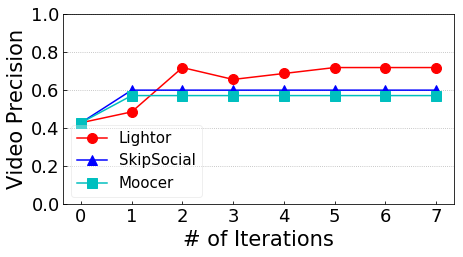

In [12]:
end_plot = [
    [end, '-ro', 'Lightor'],
    [[end[0]] + [skipsocial[1]] * 7, '-b^', 'SkipSocial'],
    [[end[0]] + [moocer[1]] * 7, '-cs', 'Moocer']
]

plot_precision(end_plot, '# of Iterations', 'Video Precision', list(range(0, iternum + 1)), [0, 1], np.arange(0, 1.1, 0.2))

# Applicability

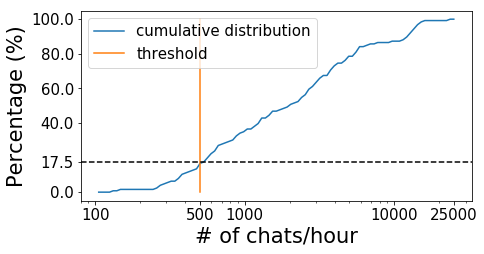

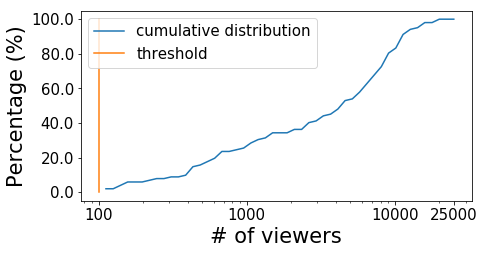

<Figure size 432x288 with 0 Axes>

In [13]:
plot_trends()

# Comparison with Deep Learning

In [14]:
k = 10
expander = Adjustment(lol_train_data, **EXPAND)
expander.train()

lol_on_lol_DL_123, _ = evaluate_initializer(k, 'LOL_123_labels', lol_test_data)
lol_on_lol_DL_1, _ = evaluate_initializer(k, 'LOL_1_label', lol_test_data)
lol_on_dota_DL_123, _ = evaluate_initializer(k, 'Dota2_123_labels', dota2_test_data)
lol_on_dota_DL_1, _ = evaluate_initializer(k, 'Dota2_1_label', dota2_test_data)


lol_on_lol_lightor = []
lol_on_dota_lightor = []



apply_model(lol_model, lol_test_data, 120, [4, 5, 6])
apply_model(lol_model, dota2_test_data, 120, [4, 5, 6])
expander.generate_peaks(dota2_test_data, **EXPAND)
expander.apply(dota2_test_data)
expander.generate_peaks(lol_test_data, **EXPAND)
expander.apply(lol_test_data)

for i in range(1, k + 1):
    true_num = [0, 0]
    for f in lol_test_data.chat:
        pred = lol_test_data.predicted_labels[f][:i]
        true_num[0] += len([p for p in pred if p[-1] in lol_test_data.start_gt[f]])
        
    for f in dota2_test_data.chat:
        pred = dota2_test_data.predicted_labels[f][:i]
        true_num[1] += len([p for p in pred if p[-1] in dota2_test_data.start_gt[f]])
    lol_on_lol_lightor.append(true_num[0] / float(i * len(lol_test_data.predicted_labels)))
    lol_on_dota_lightor.append(true_num[1] / float(i * len(dota2_test_data.predicted_labels)))

data_size_plot = [
    [lol_on_lol_lightor, 'Lightor (1 labeled video)'],
    [lol_on_lol_DL_1, 'Chat-LSTM (1 labeled video)'],
    [lol_on_lol_DL_123, 'Chat-LSTM (123 labeled videos)']
]

generalization_plot = [
    [lol_on_lol_lightor, 'LOL model(Lightor) on LOL data'],
    [lol_on_dota_lightor, 'LOL model(Lightor) on Dota2 data'],
    [lol_on_lol_DL_123, 'LOL model(Chat-LSTM) on LOL data'],
    [lol_on_dota_DL_123, 'LOL model (Chat-LSTM) on Dota2 data']
]

# Training Size

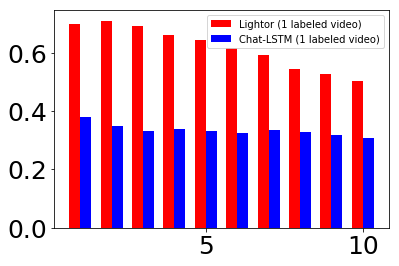

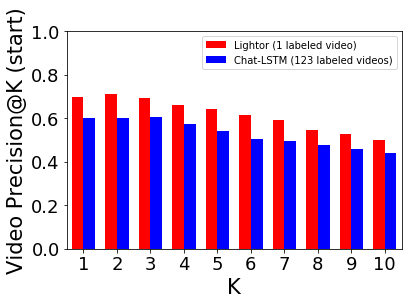

In [15]:
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=18)
plt.ylim(0, 1)
bar_width = 0.35
plt.xticks(np.arange(1, 11, 1), fontsize=18)
plt.xlim(0.5, 10.5)

plt.xlabel('K', fontsize=21)
plt.ylabel('Video Precision@K (start)', fontsize=21)

plt.figure(0)

plt.bar(np.arange(1, 11, 1) - bar_width / 2, data_size_plot[0][0], bar_width, label=data_size_plot[0][1], color='r')
plt.bar(np.arange(1, 11, 1) + bar_width / 2, data_size_plot[1][0], bar_width, label=data_size_plot[1][1], color='b')
plt.legend()
plt.figure(1)

plt.bar(np.arange(1, 11, 1) - bar_width / 2, data_size_plot[0][0], bar_width, label=data_size_plot[0][1], color='r')
plt.bar(np.arange(1, 11, 1) + bar_width / 2, data_size_plot[2][0], bar_width, label=data_size_plot[2][1], color='b')
plt.legend()

# Generalization

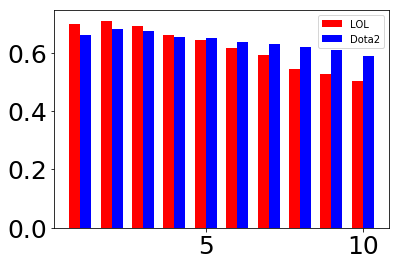

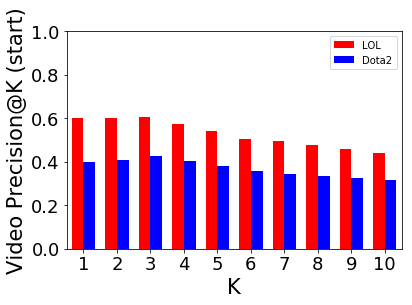

In [16]:
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=18)
plt.ylim(0, 1)
bar_width = 0.35
plt.xticks(np.arange(1, 11, 1), fontsize=18)
plt.xlim(0.5, 10.5)

plt.xlabel('K', fontsize=21)
plt.ylabel('Video Precision@K (start)', fontsize=21)

plt.figure(0)
plt.bar(np.arange(1, 11, 1) - bar_width / 2, generalization_plot[0][0], bar_width, label='LOL', color='r')
plt.bar(np.arange(1, 11, 1) + bar_width / 2, generalization_plot[1][0], bar_width, label='Dota2', color='b')
plt.legend()

plt.figure(1)
plt.bar(np.arange(1, 11, 1) - bar_width / 2, generalization_plot[2][0], bar_width, label='LOL', color='r')
plt.bar(np.arange(1, 11, 1) + bar_width / 2, generalization_plot[3][0], bar_width, label='Dota2', color='b')
plt.legend()

# End to End

In [17]:
subfiles = ['sing_sing-2017-08-01-10h09m35s 1501607375025.csv',
 'sing_sing-2017-08-01-09h09m34s 1501603774006.csv',
 'moonmeander-2017-07-03-19h17m57s 1499134677832.csv',
 'moonmeander-2017-07-03-17h17m56s 1499127476823.csv',
 'attackerdota-2017-07-31-02h34m10s 1501493650241.csv',
 'attackerdota-2017-07-31-01h34m09s 1501490049886.csv',
 'attackerdota-2017-07-30-23h34m09s 1501482849130.csv']
dota2_end_to_end_dataset = DataLoader('Dota2', 'test', subfiles=subfiles, **INITIAL_PARA)
end_to_end_DL_123 = evaluate_end_to_end(5, 'Dota2_end_to_end', dota2_end_to_end_dataset)
print('start precision', end_to_end_DL_123[0])
print('end precision', end_to_end_DL_123[1])

start precision 0.6285714285714286
end precision 0.6
